In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import ensemble_model.preprocesser as preprocesser 
import ensemble_model.ensemble_model_backuo as em 
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer, RobertaModel, RobertaTokenizer
import whatthepatch
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Load BERT and CodeBERT models and tokenizers
bert_model = BertModel.from_pretrained('/root/autodl-tmp/models/bert-base-cased')
bert_tokenizer = BertTokenizer.from_pretrained('/root/autodl-tmp/models/bert-base-cased')

codebert_model = RobertaModel.from_pretrained('/root/autodl-tmp/models/codebert-base')
codebert_tokenizer = RobertaTokenizer.from_pretrained('/root/autodl-tmp/models/codebert-base')

Some weights of the model checkpoint at /root/autodl-tmp/models/bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
train_data = pd.read_csv('train.csv')
# train_data.rename(columns={'message':'command','label':'message','command':'label'},inplace=True)


In [4]:
train_data

,Unnamed: 0.1,Unnamed: 0,command,label,message
0,0,0,check_admin_token();$nw_subject = isset($_POST...,1,XSS 취약점 수정
1,1,1,\t\tif ( endp->in_hdr )\t\t\t{\t\t\t// We're p...,1,DNP3: fix reachable assertion and buffer over-...
2,2,2,"function highlight($text, array $words){\t$wor...",0,Merge pull request #6480 from BrickOzp/search\...
3,3,3,# this script generates for each plugin:# - li...,0,[report] add a script to print plugins' overvi...
4,4,4,@Override protected RemoteCacheManager ge...,0,ISPN-12596 Incorrect Hotrod Multimap get KeyDo...
...,...,...,...,...,...
7744,7744,7744,Orange Forum============[Orange Forum](http://...,0,Skeleton
7745,7745,7745,/* Finalize message. */ r = receiver->e...,0,index: log errors and partially indexed messag...
7746,7746,7746,<script>/* fix for ajax-loading tooltips */$('...,0,Subnet map fixes
7747,7747,7747,if (message.status == NegotiationStatu...,1,THRIFT-4506: fix use of assert for correctness...


In [5]:
val_data = pd.read_csv('val.csv')
val_data

,Unnamed: 0,message,command,label
0,0,"Update PR feedback, add more tests",7) If the current class implementa...,0
1,1,Merge pull request #58 from leizleiz/leizleiz-...,int32_t ReadableFontData::ReadUByte(int32_t in...,0
2,2,Factor out glyph buffer retrieval,uint32_t current_offset = 0; for (unsigned ...,0
3,3,Remove SpelView in WhitelabelApprovalEndpoint\...,package org.springframework.security.oauth2.pr...,1
4,4,"Disable stdout buffering sometimes, to make su...",\t// According to the documentation of WriteCo...,0
...,...,...,...,...
1933,1933,Reset version string to commit hash,1.0.1 $Format:<%h>$,0
1934,1934,Default to zero for hlsLiveSyncPosition\n\nfix...,// API overriders engineApi.resume = fu...,0
1935,1935,[Object] optimized bulk import,use Pimcore\Model\Asset;use Pimcore\Model\Data...,1
1936,1936,api: storage_volume_state extension\n\nSigned-...,"\t""instance_pool_move"",\t""gpu_sriov"",\t""pci_de...",0


/root/miniconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


=============================train========================
Epoch 1/1, Loss: 0.3794682610364798
=============================eval========================
Validation Accuracy: 0.8766769865841073
Precision: 0.8823244757368827
Recall: 0.8766769865841073
F1-Score: 0.8722531777309231
Epoch 1/1, Validation Accuracy: 0.8766769865841073
当前best acc 0.8766769865841073


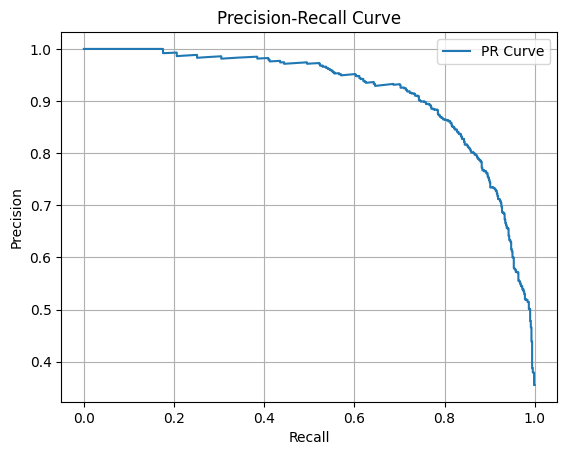

embedding来啦 (1536,)


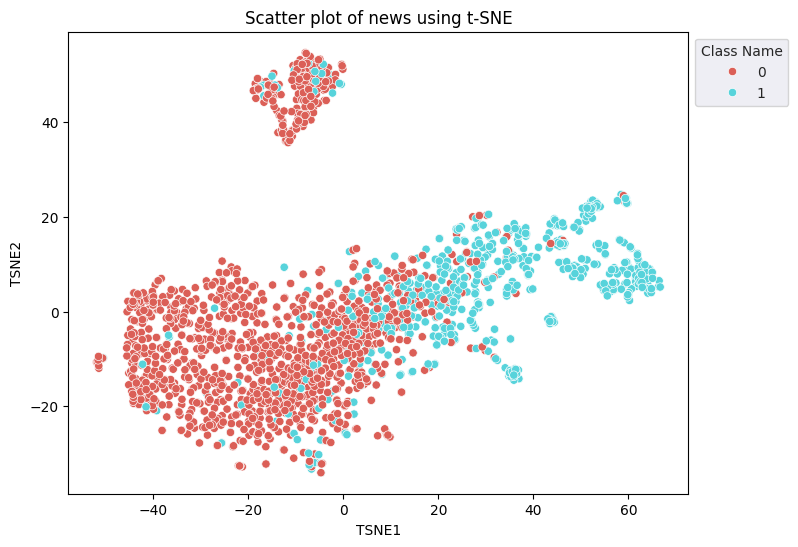

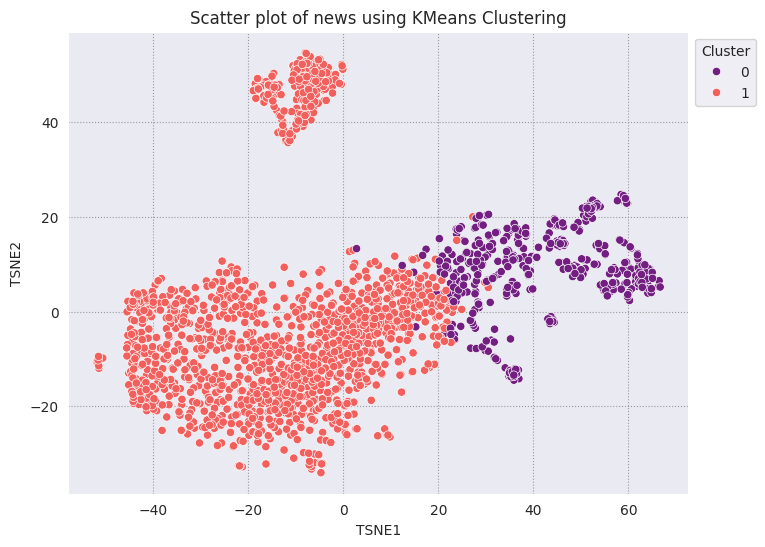

In [6]:
# Create Datasets and DataLoaders
train_dataset = preprocesser.SentencePairDataset(train_data, bert_tokenizer, codebert_tokenizer)
val_dataset = preprocesser.SentencePairDataset(val_data, bert_tokenizer, codebert_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)




# # Initialize the model
# model = em.CombinedModel(bert_model, codebert_model, bert_tokenizer, codebert_tokenizer)

# # Train the model
# model.trainer(train_loader, val_loader,num_epochs=10)
# for batch in train_loader:
#     print(batch)


base_model1 = em.BaseModel(bert_model,bert_tokenizer)
base_model2 = em.BaseModel(codebert_model,codebert_tokenizer)

# Create stacking model
stacking_model = em.StackingModel(base_model1, base_model2)
# Train the model
stacking_model.trainer(train_loader, val_loader,num_epochs=1, patience=3)

In [7]:
1

1

In [8]:
# trainer.model.save_pretrained(nb_fname)